# Regression models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
#from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C

from pylab import cm
from matplotlib import colors as mcol

from netCDF4 import Dataset as NetCDFFile

In [2]:
with open("camels_attributes.csv", "r") as f:
    df_attributes = pd.read_csv(f, index_col="gauge_id")
with open("camels_hydrologic_signatures.csv", "r") as f:
    df_hydrologic_signatures = pd.read_csv(f, index_col="gauge_id")
with open("camels_recurrence_intervals.csv", "r") as f:
    df_recurrence_intervals = pd.read_csv(f, index_col="gauge_id")

In [5]:
def regress_recurrence(df_attributes, df_recurrence_intervals, target_ri_period):
    X=np.array(df_attributes)
    y=np.array(df_recurrence_intervals[f"ri_{target_ri_period}"])
    A=np.array(df_attributes['area_geospa_fabric'])
    # SET UP K-FOLD
    # Split into training groups
    kf = KFold(n_splits=5, shuffle=True)
    kf.get_n_splits(X)
    # GPR (Kriging) in a K-fold loop
    rmse_list = []
    r_sq_list = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        A_train, A_test = A[train_index], A[test_index]

        rf = RandomForestRegressor(n_estimators=100, random_state=42,
                                      criterion="absolute_error", min_samples_leaf=1,
                                      min_samples_split=2, max_depth=None,
                                      min_weight_fraction_leaf=0)

        rf.fit(X_train, y_train)

        y_hat = rf.predict(X_test) 

        rmse_list.append(np.sqrt(np.mean((y_test - y_hat)**2)))

        correlation_matrix = np.corrcoef(y_test, y_hat)
        correlation_xy = correlation_matrix[0,1]
        r_sq_list.append(correlation_xy**2)

        plt.scatter(y_test/A_test, y_hat/A_test, c="b")
        print('rmse: {:.2f}, r-squared: {:.2f}'.format(rmse_list[-1],r_sq_list[-1]))

    plt.plot([10,2000],[10,2000], 'k')
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    plt.title(f"{target_ri_period}-year recurrence interval (area normalized)")
    plt.xlim([10,2000])
    plt.xscale('log')
    plt.ylim([10,2000])
    plt.yscale('log')
    plt.show()
    print('Mean values:')
    print(f'rmse: {np.mean(rmse_list):.2f}, r-squared: {np.mean(r_sq_list):.2f}')

rmse: 94150.39, r-squared: 0.16
rmse: 157722.07, r-squared: 0.11
rmse: 74358.76, r-squared: 0.06
rmse: 29839.81, r-squared: 0.40
rmse: 30219.98, r-squared: 0.39


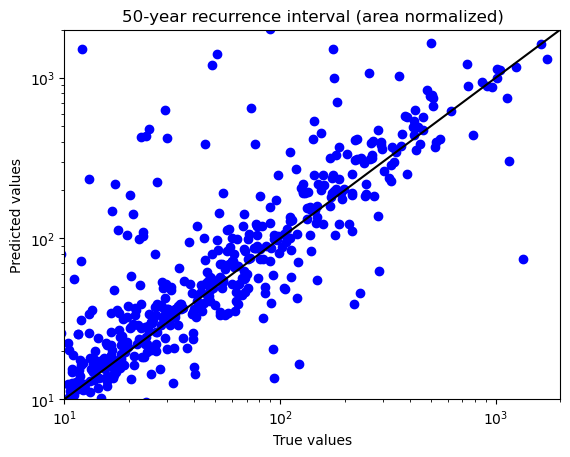

Mean values:
rmse: 77258.20, r-squared: 0.22


In [6]:
regress_recurrence(df_attributes, df_recurrence_intervals, 50)